# EmotionNet-Lite Training

**Author**: Suneth (FC211003)  
**Date**: November 2, 2025  
**Purpose**: Train custom CNN model for emotion recognition

## Model Architecture: EmotionNet-Lite

A lightweight CNN optimized for 48x48 grayscale emotion images with 5 classes:
- **happy**, **sad**, **neutral**, **angry**, **surprised**

### Architecture Overview:
- 4 Convolutional Blocks (32 → 64 → 128 → 256 filters)
- Batch Normalization after each conv layer
- Progressive Dropout (0.25 → 0.25 → 0.4 → 0.5)
- GlobalAveragePooling instead of Flatten
- Single Dense hidden layer (128 units)
- ~500K-600K parameters (lightweight & deployable)

## 1. Import Libraries

In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Check Requiremnts\n================================")
print(f"1. TensorFlow version: {tf.__version__}")
print(f"2. GPU Available: {tf.config.list_physical_devices('GPU')}")


Check Requiremnts
1. TensorFlow version: 2.13.0
2. GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Configuration

Set paths and training hyperparameters.

In [91]:
DATA_DIR = "/app/data/processed/FC211003_Suneth"
TRAIN_FILE = os.path.join(DATA_DIR, "train.npz")
VAL_FILE = os.path.join(DATA_DIR, "val.npz")
TEST_FILE = os.path.join(DATA_DIR, "test.npz")

MODEL_DIR = "/app/models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_NAME = "emotion_model_fc211003_suneth"
MODEL_PATH = os.path.join(MODEL_DIR, f"{MODEL_NAME}.h5")
WEIGHTS_PATH = os.path.join(MODEL_DIR, f"{MODEL_NAME}_weights.h5")

# TRAINING PARAMETERS ==========
BATCH_SIZE = 32      
EPOCHS = 40          # Reduced from 50
LEARNING_RATE = 0.001  # Standard learning rate

# MODEL PARAMETERS ========================
INPUT_SHAPE = (48, 48, 1)
NUM_CLASSES = 5

print("\n" + "=" * 60)
print("Configuration Summary")
print("=" * 60)
print(f"Data Directory : {DATA_DIR}")
print(f"Model Path     : {MODEL_PATH}")
print(f"\nTraining Parameters")
print(f"   • Batch size    : {BATCH_SIZE}")
print(f"   • Epochs        : {EPOCHS}")
print(f"   • Learning rate : {LEARNING_RATE}")



Configuration Summary
Data Directory : /app/data/processed/FC211003_Suneth
Model Path     : /app/models/emotion_model_fc211003_suneth.h5

Training Parameters
   • Batch size    : 32
   • Epochs        : 40
   • Learning rate : 0.001


## 4. Load Datasets

Load the preprocessed training, validation, and test datasets.

In [92]:
print("\n" + "=" * 70)
print("Dataset Loading Summary".center(70))
print("=" * 70)

# Load training data
train_data = np.load(TRAIN_FILE)
X_train, y_train = train_data["X"], train_data["y"]
label_names = train_data["label_names"]

val_data = np.load(VAL_FILE)
X_val, y_val = val_data["X"], val_data["y"]

test_data = np.load(TEST_FILE)
X_test, y_test = test_data["X"], test_data["y"]

# Print table header
print(f"{'Dataset':<15} {'X shape':<25} {'y shape':<25}")
print("-" * 70)
print(f"{'Train':<15} {str(X_train.shape):<25} {str(y_train.shape):<25}")
print(f"{'Validation':<15} {str(X_val.shape):<25} {str(y_val.shape):<25}")
print(f"{'Test':<15} {str(X_test.shape):<25} {str(y_test.shape):<25}")
print("-" * 70)
print(f"{'Labels':<15} {', '.join(label_names)}")

print("=" * 70)
print("All datasets loaded successfully".center(70))
print("=" * 70 + "\n")



                       Dataset Loading Summary                        
Dataset         X shape                   y shape                  
----------------------------------------------------------------------
Train           (11610, 48, 48, 1)        (11610, 5)               
Validation      (2489, 48, 48, 1)         (2489, 5)                
Test            (2489, 48, 48, 1)         (2489, 5)                
----------------------------------------------------------------------
Labels          angry, happy, neutral, sad, surprised
                   All datasets loaded successfully                   

Dataset         X shape                   y shape                  
----------------------------------------------------------------------
Train           (11610, 48, 48, 1)        (11610, 5)               
Validation      (2489, 48, 48, 1)         (2489, 5)                
Test            (2489, 48, 48, 1)         (2489, 5)                
---------------------------------------------

## 5. Data Augmentation Setup

Create an image data generator for training data augmentation to improve generalization.

In [93]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,          # Moderate rotation
    width_shift_range=0.1,      # Moderate shifts
    height_shift_range=0.1,     
    horizontal_flip=True,       # Mirror faces
    zoom_range=0.1,             # Slight zoom
    fill_mode='nearest'         
)

# No augmentation for validation and test
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

print("\nAugmentation parameters:")
print(f"   • Rotation range: ±15°")
print(f"   • Width shift: ±10%")
print(f"   • Height shift: ±10%")
print(f"   • Horizontal flip: Yes")
print(f"   • Zoom range: ±10%")



Augmentation parameters:
   • Rotation range: ±15°
   • Width shift: ±10%
   • Height shift: ±10%
   • Horizontal flip: Yes
   • Zoom range: ±10%


## 6. Build EmotionNet-Lite Model

Custom CNN architecture optimized for small grayscale emotion images.

In [ ]:
def build_emotionnet_lite(input_shape=(48, 48, 1), num_classes=5):
    """
    Build EmotionNet-Lite V2: Balanced CNN for emotion recognition
    
    Architecture:
    - 4 Convolutional Blocks (32 → 64 → 128 → 256) - Optimal for 48x48
    - BatchNorm after each Conv2D
    - Moderate Dropout (0.25 → 0.3 → 0.4 → 0.5)
    - GlobalAveragePooling
    - Single wider Dense layer (256 units)
    """
    
    model = models.Sequential(name='EmotionNet_Lite_V2')
    
    # ========== BLOCK 1: Low-level features ==========
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                            input_shape=input_shape, name='block1_conv1'))
    model.add(layers.BatchNormalization(name='block1_bn1'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2'))
    model.add(layers.BatchNormalization(name='block1_bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='block1_pool'))
    model.add(layers.Dropout(0.25, name='block1_dropout'))
    
    # ========== BLOCK 2: Mid-level features ==========
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'))
    model.add(layers.BatchNormalization(name='block2_bn1'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2'))
    model.add(layers.BatchNormalization(name='block2_bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='block2_pool'))
    model.add(layers.Dropout(0.3, name='block2_dropout'))
    
    # ========== BLOCK 3: High-level features ==========
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1'))
    model.add(layers.BatchNormalization(name='block3_bn1'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2'))
    model.add(layers.BatchNormalization(name='block3_bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='block3_pool'))
    model.add(layers.Dropout(0.4, name='block3_dropout'))
    
    # ========== BLOCK 4: Deep features ==========
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1'))
    model.add(layers.BatchNormalization(name='block4_bn1'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv2'))
    model.add(layers.BatchNormalization(name='block4_bn2'))
    model.add(layers.GlobalAveragePooling2D(name='block4_gap'))
    model.add(layers.Dropout(0.5, name='block4_dropout'))
    
    # ========== CLASSIFICATION HEAD ==========
    model.add(layers.Dense(256, activation='relu', name='fc1'))
    model.add(layers.BatchNormalization(name='fc1_bn'))
    model.add(layers.Dropout(0.4, name='fc1_dropout'))
    model.add(layers.Dense(num_classes, activation='softmax', name='predictions'))
    
    return model

# Build the model
print("Building EmotionNet-Lite V2...\n")
model = build_emotionnet_lite(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

print("Model built successfully")
print(f"Architecture: 4 Conv Blocks + Balanced Dropout")
print(f"Optimized for 48x48 emotion recognition\n")


Building EmotionNet-Lite V2...

Model built successfully
Architecture: 4 Conv Blocks + Balanced Dropout
Optimized for 48x48 emotion recognition

Model built successfully
Architecture: 4 Conv Blocks + Balanced Dropout
Optimized for 48x48 emotion recognition



## 7. Model Summary

In [95]:
model.summary()

Model: "EmotionNet_Lite_V2"
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 32)        320       
                                                                 
 block1_bn1 (BatchNormaliza  (None, 48, 48, 32)        128       
 tion)                                                           
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 32)        320       
                                                                 
 block1_bn1 (BatchNormaliza  (None, 48, 48, 32)        128       
 tion)                                                           
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 32)        9248      
                                                

## 8. Compile Model

In [96]:
# Define Focal Loss for better handling of hard examples
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss: Focuses training on hard misclassified examples
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Balance parameter for class importance
    
    Better than standard cross-entropy for:
    - Hard-to-classify samples (angry, sad, neutral confusion)
    - Reducing easy example dominance
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Focal loss weight: focus on hard examples
        weight = alpha * y_true * K.pow(1.0 - y_pred, gamma)
        
        # Weighted loss
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    
    return focal_loss_fixed

print("Focal Loss defined")
print("Benefits:")
print("   - Focuses on hard examples (angry/sad/neutral confusion)")
print("   - Reduces overconfident predictions")
print("   - Better gradient flow for minority patterns")


Focal Loss defined
Benefits:
   - Focuses on hard examples (angry/sad/neutral confusion)
   - Reduces overconfident predictions
   - Better gradient flow for minority patterns


In [97]:
# Compile the model with standard categorical cross-entropy
optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Using reliable standard loss
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("Model compiled successfully")
print(f"\nCompilation details:")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Loss: categorical_crossentropy")
print(f"   Metrics: accuracy, AUC")


Model compiled successfully

Compilation details:
   Optimizer: Adam (lr=0.001)
   Loss: categorical_crossentropy
   Metrics: accuracy, AUC


## 9. Setup Callbacks

Configure callbacks for training monitoring and optimization.

In [98]:
# Create logs directory
log_dir = os.path.join(MODEL_DIR, "logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

# ModelCheckpoint: Save best model
checkpoint = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EarlyStopping: Stop if no improvement
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# TensorBoard: Log for visualization
tensorboard = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

callbacks = [checkpoint, early_stop, reduce_lr, tensorboard]

print("Callbacks configured")
print(f"\nCallback details:")
print(f"   ModelCheckpoint: Save best model (val_accuracy)")
print(f"   EarlyStopping: Patience=10 epochs (val_loss)")
print(f"   ReduceLROnPlateau: Factor=0.5, Patience=5")
print(f"   TensorBoard: Logs -> {log_dir}")


Callbacks configured

Callback details:
   ModelCheckpoint: Save best model (val_accuracy)
   EarlyStopping: Patience=10 epochs (val_loss)
   ReduceLROnPlateau: Factor=0.5, Patience=5
   TensorBoard: Logs -> /app/models/logs/20251104-051417


## 10. Train Model

Train the EmotionNet-Lite model with data augmentation.

In [99]:
print("Starting training...\n")
print("="*60)

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("Training completed")


Starting training...

Epoch 1/40
Epoch 1/40


2025-11-04 05:14:37.560776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEmotionNet_Lite_V2/block1_dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


362/362 [==============================] - ETA: 0s - loss: 2.0001 - accuracy: 0.2223 - auc: 0.5323
Epoch 1: val_accuracy improved from -inf to 0.22579, saving model to /app/models/emotion_model_fc211003_suneth.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


362/362 [==============================] - 54s 68ms/step - loss: 2.0001 - accuracy: 0.2223 - auc: 0.5323 - val_loss: 1.7006 - val_accuracy: 0.2258 - val_auc: 0.5387 - lr: 0.0010
Epoch 2/40
362/362 [==============================] - ETA: 0s - loss: 1.6943 - accuracy: 0.2538 - auc: 0.5715
Epoch 2: val_accuracy did not improve from 0.22579
362/362 [==============================] - 22s 62ms/step - loss: 1.6943 - accuracy: 0.2538 - auc: 0.5715 - val_loss: 2.1318 - val_accuracy: 0.1796 - val_auc: 0.5318 - lr: 0.0010
Epoch 3/40
361/362 [============================>.] - ETA: 0s - loss: 1.5290 - accuracy: 0.3186 - auc: 0.6503
Epoch 3: val_accuracy improved from 0.22579 to 0.31097, saving model to /app/models/emotion_model_fc211003_suneth.h5
362/362 [==============================] - 23s 63ms/step - loss: 1.5286 - accuracy: 0.3187 - auc: 0.6505 - val_loss: 1.5670 - val_accuracy: 0.3110 - val_auc: 0.6389 - lr: 0.0010
Epoch 4/40
362/362 [==============================] - ETA: 0s - loss: 1.3788 -

## 11. Training History Visualization

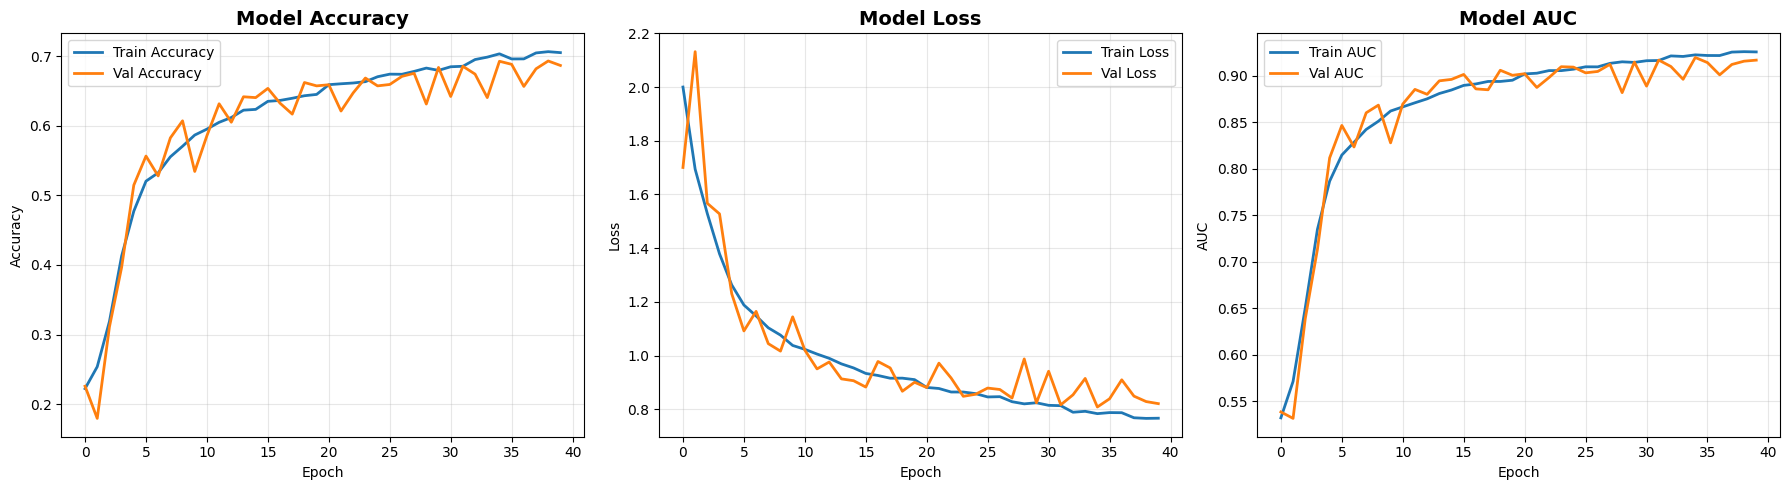


Best Validation Accuracy:
   Epoch: 39
   Accuracy: 0.6930
   Loss: 0.8287


In [100]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[2].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy:")
print(f"   Epoch: {best_epoch + 1}")
print(f"   Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"   Loss: {history.history['val_loss'][best_epoch]:.4f}")


## 12. Evaluate on Test Set

In [101]:
print("Evaluating model on test set...\n")

# Load best model
best_model = keras.models.load_model(MODEL_PATH)

# Evaluate
test_loss, test_accuracy, test_auc = best_model.evaluate(X_test, y_test, verbose=0)

print("="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test AUC:      {test_auc:.4f}")
print("="*60)


Evaluating model on test set...

TEST SET RESULTS
Test Loss:     0.8251
Test Accuracy: 0.6798 (67.98%)
Test AUC:      0.9163


## 13. Confusion Matrix

78/78 [==============================] - 1s 13ms/step


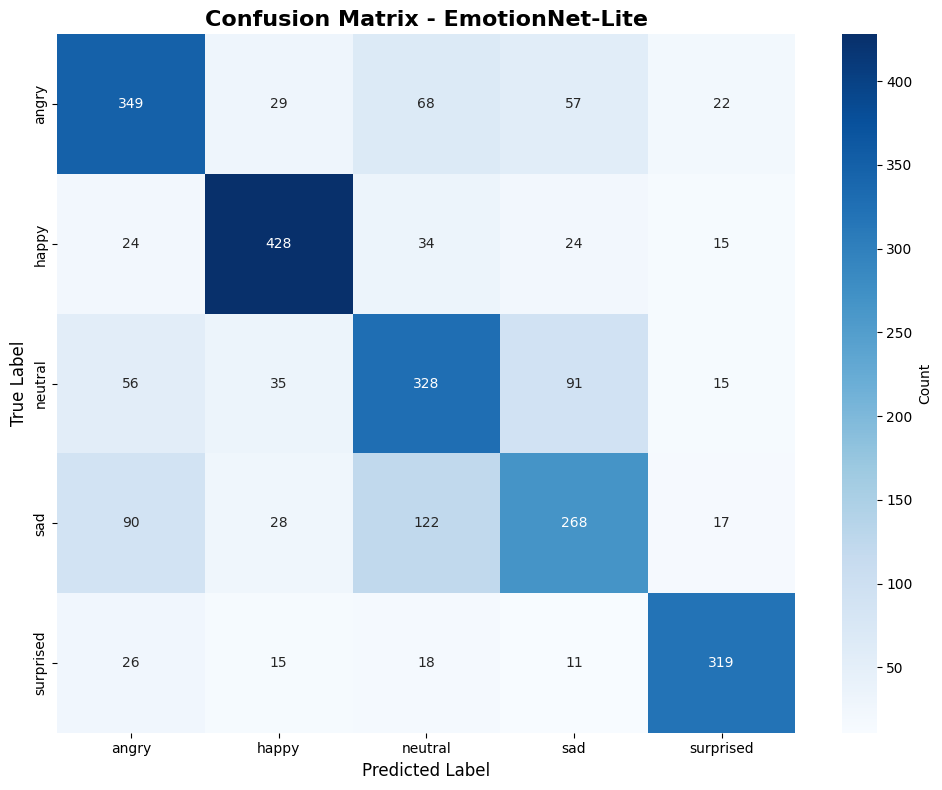


Classification Report:
              precision    recall  f1-score   support

       angry     0.6404    0.6648    0.6523       525
       happy     0.8000    0.8152    0.8075       525
     neutral     0.5754    0.6248    0.5991       525
         sad     0.5942    0.5105    0.5492       525
   surprised     0.8222    0.8201    0.8211       389

    accuracy                         0.6798      2489
   macro avg     0.6864    0.6871    0.6859      2489
weighted avg     0.6790    0.6798    0.6785      2489



In [102]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - EmotionNet-Lite', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=label_names, digits=4))
print("="*60)


## 14. Per-Class Accuracy

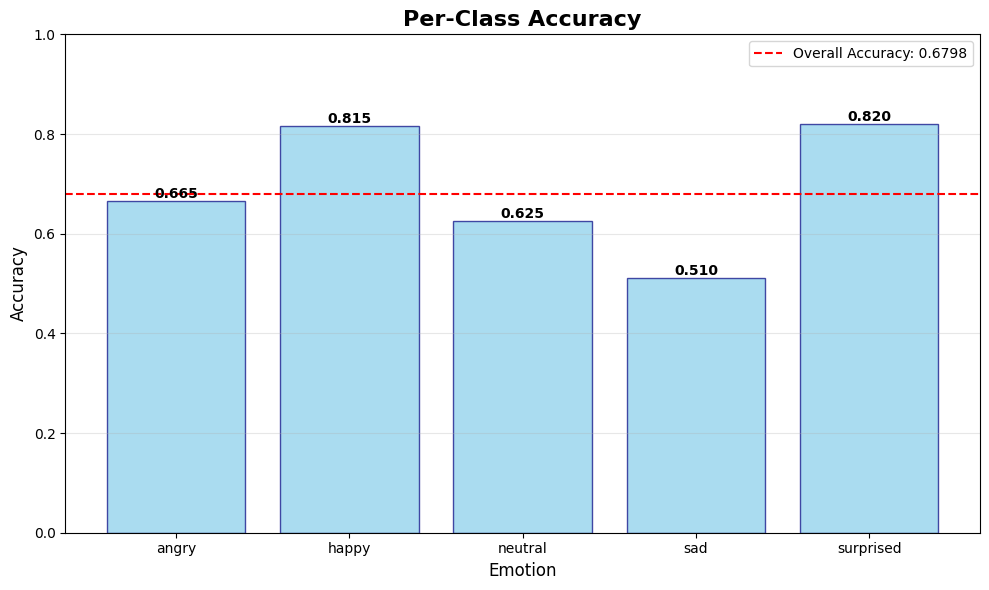


Per-Class Accuracy:
       angry: 0.6648 (66.48%)
       happy: 0.8152 (81.52%)
     neutral: 0.6248 (62.48%)
         sad: 0.5105 (51.05%)
   surprised: 0.8201 (82.01%)


In [103]:
# Calculate per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Plot per-class accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, class_accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Overall Accuracy: {test_accuracy:.4f}')
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0, 1])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPer-Class Accuracy:")
print("="*60)
for emotion, acc in zip(label_names, class_accuracies):
    print(f"{emotion:>12}: {acc:.4f} ({acc*100:.2f}%)")
print("="*60)


## 15. Sample Predictions Visualization

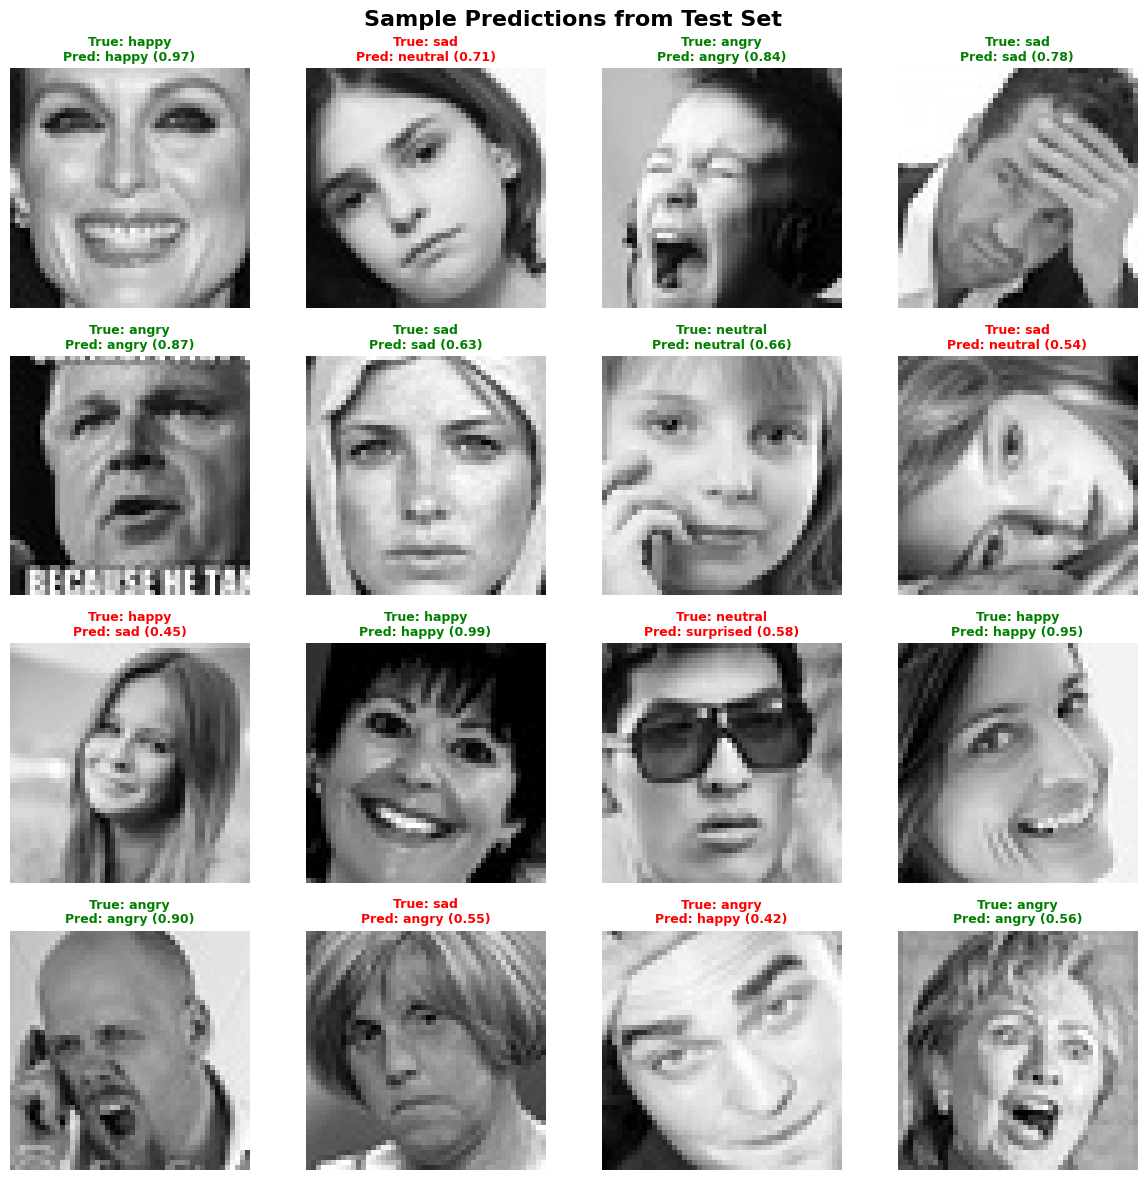

In [104]:
# Visualize sample predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample Predictions from Test Set', fontsize=16, fontweight='bold')

# Randomly select 16 samples
indices = np.random.choice(len(X_test), 16, replace=False)

for idx, ax in zip(indices, axes.flatten()):
    img = X_test[idx].squeeze()
    true_label = label_names[y_true_classes[idx]]
    pred_label = label_names[y_pred_classes[idx]]
    confidence = y_pred[idx][y_pred_classes[idx]]
    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
    # Color: green if correct, red if wrong
    color = 'green' if true_label == pred_label else 'red'
    
    ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})',
                fontsize=9, color=color, fontweight='bold')

plt.tight_layout()
plt.show()

## 16. Save Model Weights

In [105]:
# Save model weights separately
best_model.save_weights(WEIGHTS_PATH)

print(f"Model saved successfully")
print(f"\nSaved files:")
print(f"   Full model: {MODEL_PATH}")
print(f"   Weights only: {WEIGHTS_PATH}")
print(f"   TensorBoard logs: {log_dir}")


Model saved successfully

Saved files:
   Full model: /app/models/emotion_model_fc211003_suneth.h5
   Weights only: /app/models/emotion_model_fc211003_suneth_weights.h5
   TensorBoard logs: /app/models/logs/20251104-051417


## 17. Final Summary

In [106]:
print("="*60)
print("TRAINING COMPLETE - EMOTIONNET-LITE")
print("="*60)
print(f"\nModel Architecture:")
print(f"   Name: EmotionNet-Lite")
print(f"   Input: {INPUT_SHAPE}")
print(f"   Output: {NUM_CLASSES} classes")
print(f"   Parameters: {model.count_params():,}")

print(f"\nTraining Configuration:")
print(f"   Epochs trained: {len(history.history['accuracy'])}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Initial LR: {LEARNING_RATE}")
print(f"   Data augmentation: Yes")

print(f"\nBest Validation Results:")
print(f"   Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"   Loss: {min(history.history['val_loss']):.4f}")

print(f"\nFinal Test Results:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test AUC: {test_auc:.4f}")

print(f"\nModel Files:")
print(f"   {MODEL_PATH}")
print(f"   {WEIGHTS_PATH}")

print(f"\nModel ready for deployment")
print("="*60)


TRAINING COMPLETE - EMOTIONNET-LITE

Model Architecture:
   Name: EmotionNet-Lite
   Input: (48, 48, 1)
   Output: 5 classes
   Parameters: 1,243,621

Training Configuration:
   Epochs trained: 40
   Batch size: 32
   Initial LR: 0.001
   Data augmentation: Yes

Best Validation Results:
   Accuracy: 0.6930
   Loss: 0.8085

Final Test Results:
   Test Accuracy: 0.6798 (67.98%)
   Test Loss: 0.8251
   Test AUC: 0.9163

Model Files:
   /app/models/emotion_model_fc211003_suneth.h5
   /app/models/emotion_model_fc211003_suneth_weights.h5

Model ready for deployment
